In [17]:
import time
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib.animation import FuncAnimation
from matplotlib.figure import Figure
from matplotlib.lines import Line2D


class Plotter:
    def __init__(
            self,
            title_: str = '',
            fig_size: tuple = (15, 5)
    ):
        self.title = title_
        self.p_axs: list[PlotterAx] = []
        self.fig: Figure = plt.figure(figsize=fig_size)

    def get_ax(self, pos: int) -> plt.Axes:
        return self.fig.add_subplot(pos)

    def add_p_ax(self, p_ax_: 'PlotterAx'):
        self.p_axs.append(p_ax_)

    def plot(self, animate: bool = True, clear_output_: bool = False):
        if self.title != '':
            self.fig.suptitle(self.title)
        for pax in self.p_axs:
            pax.plot()

        if animate:
            _ani = FuncAnimation(
                self.fig,
                self.plot_callback,
                blit=True,
                interval=17  # for 60 fps use interval=17
            )
        plt.tight_layout()
        if clear_output_:
            clear_output(wait=True)
        plt.show()

    def plot_callback(self, frame) -> tuple:
        r_ = tuple(pax.plot_callback() for pax in self.p_axs)
        self.fig.canvas.draw()
        return r_


class PlotterAx:
    def __init__(
            self,
            ax_: plt.Axes,
            queue_: mp.Queue,
            title: str = 'Rewards',
            label: str = 'Rewards',
            xlabel: str = 'Episode',
            ylabel: str = 'Sum of rewards'
    ):
        self.ax: plt.Axes = ax_
        self.queue = queue_
        self.title = title
        self.label = label
        self.xlabel = xlabel
        self.ylabel = ylabel

        _current_data = self.get_current_data()
        self.ax.set_title(_current_data['title'])
        self.ax_line: Line2D = self.ax.plot(_current_data['x'], _current_data['y'], label=label, c='b')[0]

    def plot(self):
        self.ax.set_xlabel(self.xlabel)
        self.ax.set_ylabel(self.ylabel)
        self.ax.legend()

    def plot_callback(self):
        if not self.queue.empty():
            current_data: np.array = self.get_current_data()
            self.ax.set_title(current_data['title'])
            self.ax_line.set_xdata(current_data['x'])
            self.ax_line.set_ydata(current_data['y'])
            self.ax.relim()
            self.ax.autoscale_view()

        return self.ax_line

    def get_current_data(self) -> dict:
        current_data = None
        while not self.queue.empty():
            current_data: np.array = self.queue.get()
        if current_data is None:
            current_data = {
                'title': self.title,
                'x': [],
                'y': [],
            }
        return current_data


In [18]:
class Trainner:
    def __init__(self):
        self.experiments_count: int = 1000
        self.episodes_count: int = 100
        self.rewards: np.ndarray = np.zeros((self.experiments_count, self.episodes_count))

    def train_callback(self, queue_rewards_: mp.Queue, queue_stop_: mp.Queue):
        for i in range(self.experiments_count):
            for j in range(self.episodes_count):
                title = 'Experiment: {}/{} Episode: {}/{}'.format(
                    i + 1,
                    self.experiments_count,
                    j + 1,
                    self.episodes_count
                )
                self.rewards[i, j] = np.random.normal()
                sum_rewards = self.rewards.sum(axis=0)
                current_data = {
                    'title': title,
                    'x': np.arange(self.episodes_count),
                    'y': sum_rewards,
                }
                queue_rewards_.put(current_data)
                if not queue_stop_.empty():
                    print('stop')
                    return ''

In [19]:
def get_plot(queue_rewards_: mp.Queue):
    _p: Plotter = Plotter()
    _p.add_p_ax(PlotterAx(_p.get_ax(111), queue_rewards_))
    return _p

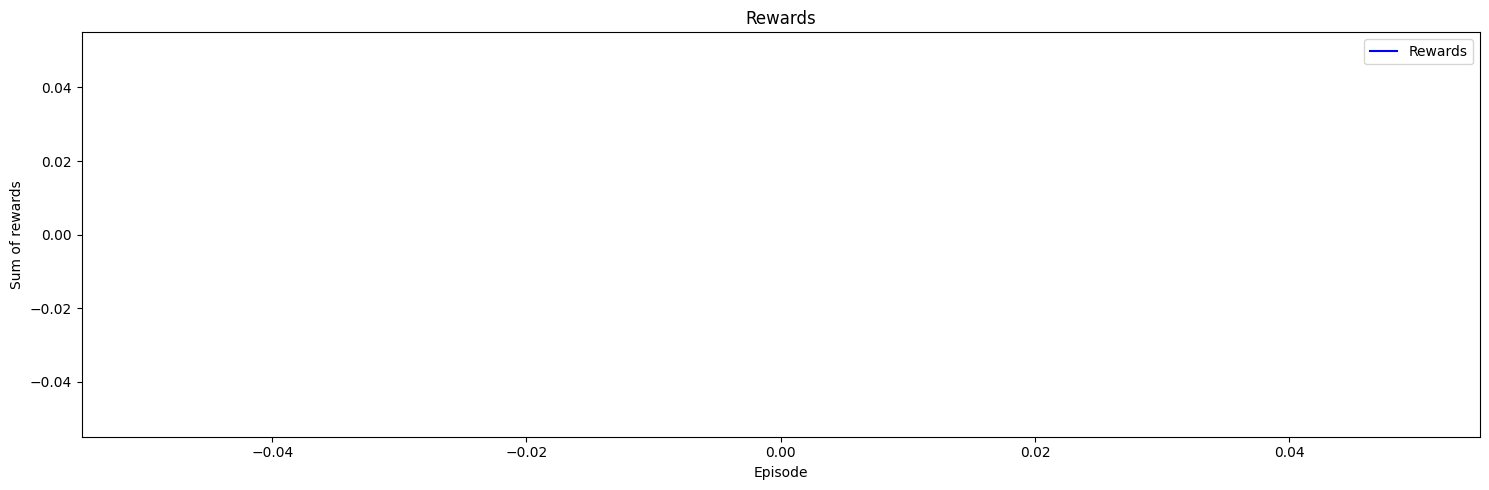

In [20]:
if __name__ == '__main__':
    queue_rewards: mp.Queue = mp.Queue()
    queue_stop: mp.Queue = mp.Queue()
    t = Trainner()

    process: mp.Process = mp.Process(
        target=t.train_callback,
        args=(queue_rewards, queue_stop),
    )
    process.start()

    for _ in range(10):
        plt.close()
        p: Plotter = get_plot(queue_rewards)
        p.plot(animate=False, clear_output_=True)
        time.sleep(1)
    queue_stop.put(1)
    # process.join()
    process.terminate()